# Example of loading and running the Euro-Calliope model
## This model includes the UK and Ireland only, and is at a 3-hourly resolution for a whole year.

Optional scenarios:
- freeze-hydro-capacities: set hydro capacities to today's values
- dispatch: run the problem as a rolling horizon optimisation, where the system does not know about weather conditions or demand more than 1 week ahead of time
- load-shedding: Include an expensive 'technology' to enable load shedding when supply is insufficient to meet demand.

`dispatch` and `load-shedding` are for use when capacities have been fixed based on an optimal run (see `Setting capacities to be fixed and re-running` later in this notebook).

In [1]:
import os

import calliope
import matplotlib.pyplot as plt
import seaborn as sns

calliope.set_log_verbosity("warning")

inputdir = "/gws/smf/j04/cop26_hackathons/oxford/group_2/euro-calliope-uk_irl"
outputdir = "~/outputs"
calliope.set_log_verbosity("warning")

if "GRB_LICENSE_FILE" not in os.environ.keys():
    os.environ["GRB_LICENSE_FILE"] = "/gws/smf/j04/cop26_hackathons/oxford/gurobi/gurobi.lic"

In [2]:
model = calliope.Model(
    os.path.join(inputdir, "national", "example-model.yaml"), 
    scenario="freeze-hydro-capacities"
)

In [3]:
model.run()

[2021-06-23 09:52:54] INFO     Loading sets
[2021-06-23 09:52:54] INFO     Loading parameters
[2021-06-23 09:52:55] INFO     constraints are loaded in the following order: ['capacity', 'costs', 'dispatch', 'energy_balance', 'network', 'policy', 'conversion', 'conversion_plus', 'group', 'export', 'milp']
[2021-06-23 09:52:55] INFO     creating capacity constraints
[2021-06-23 09:52:55] INFO     creating costs constraints
[2021-06-23 09:53:03] INFO     creating dispatch constraints
[2021-06-23 09:53:07] INFO     creating energy_balance constraints
[2021-06-23 09:53:13] INFO     creating network constraints
[2021-06-23 09:53:13] INFO     creating policy constraints
[2021-06-23 09:53:13] INFO     creating conversion constraints
[2021-06-23 09:53:13] INFO     creating conversion_plus constraints
[2021-06-23 09:53:13] INFO     creating group constraints
[2021-06-23 09:53:13] INFO     creating export constraints
[2021-06-23 09:53:13] INFO     creating milp constraints
[2021-06-23 09:53:13] DE

## Setting capacities to be fixed and re-running

In [4]:
def update_model_capacities(optimal_model, new_model, fillna=False):
    if fillna is True:
        new_model._model_data["energy_cap_equals"] = (
            new_model._model_data["energy_cap_equals"].fillna(
                optimal_model._model_data["energy_cap"]
                .where(optimal_model._model_data.loc_techs.str.find("demand") == -1)
            )
        )
        new_model._model_data["storage_cap_equals"] = (
            new_model._model_data["storage_cap_equals"].fillna(
                optimal_model._model_data["storage_cap"]
            )
        )
    else:
        new_model._model_data["energy_cap_equals"] = (
            optimal_model._model_data["energy_cap"]
            .where(optimal_model._model_data.loc_techs.str.find("demand") == -1)
        )
        new_model._model_data["storage_cap_equals"] = optimal_model._model_data["storage_cap"]

    new_model._model_data["energy_cap_equals"].attrs["is_result"] = 0
    new_model._model_data["storage_cap_equals"].attrs["is_result"] = 0

UPDATE TIMESERIES DATA HERE
e.g. 
```
new_model = calliope.Model(
    os.path.join(inputdir, "national", "example-model.yaml"), 
    scenario="freeze-hydro-capacities,my-new-timesereries"
)
update_model(model, new_model)
new_model.run()
```

In [5]:
new_model = calliope.Model(
    os.path.join(inputdir, "national", "example-model.yaml"), 
    scenario="freeze-hydro-capacities,dispatch,load-shedding"
)
update_model_capacities(model, new_model, fillna=True)

In [6]:
new_model.run()

[2021-06-23 09:57:19] WARNING  /home/users/train003/.conda/envs/euro-calliope/lib/python3.7/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Initial stored energy not defined, set to zero for all loc::techs in loc_techs_store, for use in iterative optimisation
 * Resource capacity constraint defined and set to infinity for all supply_plus techs


[2021-06-23 09:57:20] INFO     Loading sets
[2021-06-23 09:57:20] INFO     Loading parameters
[2021-06-23 09:57:20] INFO     constraints are loaded in the following order: ['capacity', 'costs', 'dispatch', 'energy_balance', 'network', 'policy', 'conversion', 'conversion_plus', 'group', 'export', 'milp']
[2021-06-23 09:57:20] INFO     creating capacity constraints
[2021-06-23 09:57:20] INFO     creating costs constraints
[2021-06-23 09:57:20] INFO     creating dispatch constraints
[2021-06-23 09:57:20] INFO     creating energy_balance constraints
[2021-06-23 09:57:20] INFO     creating ne

## Extract a metric of interest

In [8]:
# Results are in an xarray dataset `model.results`
model.results

<xarray.Dataset>
Dimensions:                                 (carriers: 1, costs: 1, loc_carriers_system_balance_constraint: 2, loc_tech_carriers_con: 10, loc_tech_carriers_prod: 24, loc_techs: 26, loc_techs_area: 4, loc_techs_balance_demand_constraint: 2, loc_techs_cost: 24, loc_techs_cost_investment_constraint: 24, loc_techs_investment_cost: 24, loc_techs_om_cost: 24, loc_techs_store: 10, loc_techs_supply_plus: 4, techs: 17, timesteps: 2928)
Coordinates:
  * loc_tech_carriers_con                   (loc_tech_carriers_con) object 'G...
  * loc_tech_carriers_prod                  (loc_tech_carriers_prod) object '...
  * loc_techs_cost                          (loc_techs_cost) object 'GBR::ac_...
  * loc_techs_cost_investment_constraint    (loc_techs_cost_investment_constraint) object ...
  * loc_techs_investment_cost               (loc_techs_investment_cost) object ...
  * loc_techs_om_cost                       (loc_techs_om_cost) object 'GBR::...
  * loc_techs_store                         (loc_techs_store) object 'GBR::ba...
  * loc_techs_supply_plus                   (loc_techs_supply_plus) object 'G...
  * techs                                   (techs) object 'ac_transmission' ...
  * costs                                   (costs) object 'monetary'
  * loc_carriers_system_balance_constraint  (loc_carriers_system_balance_constraint) object ...
  * loc_techs                               (loc_techs) object 'GBR::biofuel'...
  * loc_techs_area                          (loc_techs_area) object 'GBR::ope...
  * loc_techs_balance_demand_constraint     (loc_techs_balance_demand_constraint) object ...
  * timesteps                               (timesteps) datetime64[ns] 2016-0...
  * carriers                                (carriers) object 'electricity'
Data variables:
    energy_cap                              (loc_techs) float64 0.1191 ... 0....
    carrier_prod                            (loc_tech_carriers_prod, timesteps) float64 ...
    carrier_con                             (loc_tech_carriers_con, timesteps) float64 ...
    cost                                    (costs, loc_techs_cost) float64 0...
    resource_area                           (loc_techs_area) float64 0.05728 ...
    storage_cap                             (loc_techs_store) float64 0.503 ....
    storage                                 (loc_techs_store, timesteps) float64 ...
    resource_con                            (loc_techs_supply_plus, timesteps) float64 ...
    resource_cap                            (loc_techs_supply_plus) float64 0...
    cost_var                                (costs, loc_techs_om_cost, timesteps) float64 ...
    cost_investment                         (costs, loc_techs_investment_cost) float64 ...
    cost_investment_rhs                     (costs, loc_techs_cost_investment_constraint) float64 ...
    cost_var_rhs                            (costs, loc_techs_om_cost, timesteps) float64 ...
    system_balance                          (loc_carriers_system_balance_constraint, timesteps) float64 ...
    required_resource                       (loc_techs_balance_demand_constraint, timesteps) float64 ...
    capacity_factor                         (timesteps, loc_tech_carriers_prod) float64 ...
    systemwide_capacity_factor              (carriers, techs) float64 nan ......
    systemwide_levelised_cost               (carriers, costs, techs) float64 ...
    total_levelised_cost                    (carriers, costs) float64 0.006956
Attributes:
    termination_condition:     optimal
    objective_function_value:  27.404171633239805
    solution_time:             195.603705
    time_finished:             2021-06-22 10:27:26
    calliope_version:          0.6.7-dev
    applied_overrides:         freeze-hydro-capacities
    scenario:                  freeze-hydro-capacities
    defaults:                  available_area: null\ncarrier_ratios: false\nc...
    allow_operate_mode:        1
    model_config:              calliope_version: 0.

In [9]:
# Energy capacities, units = 100 GW
energy_capacities = model.get_formatted_array("energy_cap").to_series().dropna()
energy_capacities

locs  techs                 
GBR   ac_transmission:IRL       0.062286
      battery                   0.085649
      biofuel                   0.119065
      demand_elec               0.556920
      hydro_reservoir           0.005240
      hydro_run_of_river        0.008485
      hydrogen                  0.192393
      open_field_pv             0.458237
      pumped_hydro              0.029050
      roof_mounted_pv           0.000000
      wind_offshore             0.000000
      wind_onshore_competing    0.389218
      wind_onshore_monopoly     0.392695
IRL   ac_transmission:GBR       0.062286
      battery                   0.010492
      biofuel                   0.000000
      demand_elec               0.044527
      hydro_reservoir           0.000010
      hydro_run_of_river        0.002160
      hydrogen                  0.038702
      open_field_pv             0.000000
      pumped_hydro              0.002920
      roof_mounted_pv           0.000000
      wind_offshore         

In [13]:
# Energy production, units = 100 GWh (summed over three hours)
energy_production = model.get_formatted_array("carrier_prod").to_series().dropna()
energy_production

carriers     locs  techs                  timesteps          
electricity  GBR   ac_transmission:IRL    2016-01-01 00:00:00    0.000000
                                          2016-01-01 03:00:00    0.000000
                                          2016-01-01 06:00:00    0.000000
                                          2016-01-01 09:00:00    0.000000
                                          2016-01-01 12:00:00    0.000000
                                                                   ...   
             IRL   wind_onshore_monopoly  2016-12-31 09:00:00    0.000000
                                          2016-12-31 12:00:00    0.000000
                                          2016-12-31 15:00:00    0.123689
                                          2016-12-31 18:00:00    0.000000
                                          2016-12-31 21:00:00    0.000000
Name: carrier_prod, Length: 70272, dtype: float64

locs                      GBR       IRL
timesteps                              
2016-01-01 00:00:00  1.008770  0.139633
2016-01-01 03:00:00  0.981666  0.068490
2016-01-01 06:00:00  0.890830  0.067620
2016-01-01 09:00:00  1.267019  0.111136
2016-01-01 12:00:00  1.183130  0.214877


Text(0, 0.5, 'Weekly onshore+offshore wind energy production (100 GW)')

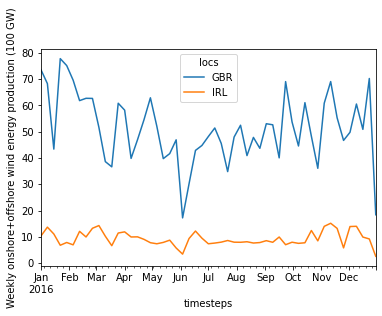

In [20]:
# Wind production
wind = (
    energy_production[energy_production.index.get_level_values("techs").str.find("wind") > -1]
    .sum(level=["locs", "timesteps"])
    .unstack("locs")
)
print(wind.head())
wind_7D_sum = wind.resample("7D").sum()
ax = wind_7D_sum.plot()
ax.set_ylabel("Weekly onshore+offshore wind energy production (100 GW)")

locs                      GBR  IRL
timesteps                         
2016-01-01 00:00:00  0.000000  0.0
2016-01-01 03:00:00  0.000000  0.0
2016-01-01 06:00:00  0.000000  0.0
2016-01-01 09:00:00  0.050836  0.0
2016-01-01 12:00:00  0.061290  0.0


Text(0, 0.5, 'Weekly PV energy production (100 GW)')

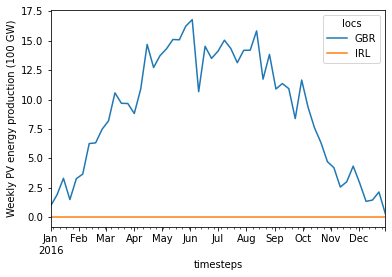

In [21]:
# PV production
pv = (
    energy_production[energy_production.index.get_level_values("techs").str.find("pv") > -1]
    .sum(level=["locs", "timesteps"])
    .unstack("locs")
)
print(pv.head())
pv_7D_sum = pv.resample("7D").sum()
ax = pv_7D_sum.plot()
ax.set_ylabel("Weekly PV energy production (100 GW)")

In [24]:
model.results.energy_cap.loc_techs

<xarray.DataArray 'loc_techs' (loc_techs: 26)>
array(['GBR::biofuel', 'GBR::ac_transmission:IRL', 'GBR::hydro_run_of_river',
       'IRL::hydro_run_of_river', 'IRL::hydrogen',
       'IRL::wind_onshore_monopoly', 'GBR::hydrogen', 'GBR::demand_elec',
       'IRL::ac_transmission:GBR', 'IRL::wind_offshore', 'IRL::battery',
       'GBR::pumped_hydro', 'GBR::roof_mounted_pv', 'IRL::open_field_pv',
       'GBR::open_field_pv', 'GBR::wind_offshore', 'IRL::roof_mounted_pv',
       'IRL::wind_onshore_competing', 'IRL::hydro_reservoir',
       'IRL::demand_elec', 'GBR::wind_onshore_monopoly',
       'GBR::wind_onshore_competing', 'GBR::battery', 'IRL::biofuel',
       'GBR::hydro_reservoir', 'IRL::pumped_hydro'], dtype=object)
Coordinates:
  * loc_techs  (loc_techs) object 'GBR::biofuel' ... 'IRL::pumped_hydro'

In [25]:
model.get_formatted_array("energy_cap")

<xarray.DataArray 'energy_cap' (locs: 2, techs: 14)>
array([[           nan, 6.22861512e-02, 8.56486260e-02, 1.19065265e-01,
        5.56920000e-01, 5.24000000e-03, 8.48475000e-03, 1.92393407e-01,
        4.58236840e-01, 2.90500000e-02, 0.00000000e+00, 0.00000000e+00,
        3.89217785e-01, 3.92694728e-01],
       [6.22861512e-02,            nan, 1.04918977e-02, 0.00000000e+00,
        4.45266667e-02, 1.00000000e-05, 2.16000000e-03, 3.87022144e-02,
        0.00000000e+00, 2.92000000e-03, 0.00000000e+00, 0.00000000e+00,
        9.15344306e-02, 8.43479216e-02]])
Coordinates:
  * locs     (locs) object 'GBR' 'IRL'
  * techs    (techs) object 'ac_transmission:GBR' ... 'wind_onshore_monopoly'
Attributes:
    is_result:  1